In [1]:
import torch
import cv2
import os
os.environ['CUDA_VISIBLE_DEVICES']='6,7'
import random
from fastvqa.apis import deep_end_to_end_vqa
from fastvqa.models import BaseEvaluator, VQABackbone
from fastvqa.datasets import VQAInferenceDataset, get_fragments, SampleFrames

from matplotlib import pyplot as plt

from scipy.stats import spearmanr, pearsonr
from scipy.stats.stats import kendalltau as kendallr
import numpy as np

from time import time
from tqdm import tqdm

## choose the device you would like to run on

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [79]:
## Calculate the finetune accuracy on small datasets

def get_finetune_results(results):
    if 'results' in results:
        results = results['results']
    srccs = np.array([r[0] for r in results])
    plccs = np.array([r[1] for r in results])
    krccs = np.array([r[2] for r in results])
    rmse = np.array([r[3] for r in results])
    ms, ss, mds = np.mean(srccs), np.std(srccs), np.median(srccs)
    mp, sp, mdp = np.mean(plccs), np.std(plccs), np.median(plccs)
    mk, sk, mdk = np.mean(krccs), np.std(krccs), np.median(krccs)
    mr, sr, mdr = np.mean(rmse), np.std(rmse), np.median(rmse)
    print(f'''In {len(results)} random split experiments,
        the mean SROCC is {ms:.4f} ({ss:.4f}), median {mds:.4f}
        the mean PLCC  is {mp:.4f} ({sp:.4f}), median {mdp:.4f}
        the mean KROCC is {mk:.4f} ({sk:.4f}), median {mdk:.4f}
        the mean RMSE  is {mr:.4f} ({sr:.4f}), median {mdr:.4f}''')

finetune_results = torch.load('results/results_finetune_live_vqc_s32*32_ens1.pkl')
finetune_results.values()
#get_finetune_results(finetune_results)

dict_values([[(0.8104047715386113, 0.8669452256798956, 0.6245210727969348, 8.69498442805143), (0.8414048640876759, 0.8597380136980519, 0.6544838275818526, 8.878324510284779), (0.8280732515098382, 0.8437028574721335, 0.6472148541114058, 10.07872284071805), (0.8439658918910817, 0.8436528948887054, 0.6584143825523135, 8.503431123505978), (0.8712104182589279, 0.8841146807602511, 0.6926024167403476, 8.861224703491589), (0.8179127515772752, 0.8264337649172788, 0.6195107574417918, 10.527743409920877), (0.8426995758965365, 0.828510515856631, 0.6507515473032713, 9.230329425650933), (0.8333633053095355, 0.8717472878272973, 0.6495726495726495, 9.072943257570897), (0.8588619640636005, 0.8500357287829319, 0.6666666666666666, 8.310504265825948), (0.8629231668390054, 0.8563727645458409, 0.6666666666666666, 8.715597283788943)]])

In [2]:
## directly insert it into your scripts

model = deep_end_to_end_vqa(pretrained=True, pretrained_path='pretrained_weights/fast_vqa_v0_3.pth',device='cuda')

video = torch.rand((3,96,224,224)).cuda()
score = model(video)
print(score['score'])

[True, True, True, False]
Successfully loaded pretrained=[True] fast-vqa model from pretrained_path=[pretrained_weights/fast_vqa_v0_3.pth].
                  Please make sure the input is [torch.tensor] in [(C,T,H,W)] layout and with data range [0,1].


/mnt/lustre/hnwu/anaconda3/envs/pt1.8v/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


-0.20654527842998505


In [2]:
## defining model and loading checkpoint

model_type = 'fast' ## 'fast' | 'faster'
 
backbone=dict(window_size=(4,4,4),frag_biases=[False,False,True,False]) if model_type=='faster' else dict()
model = BaseEvaluator(backbone=backbone).to(device)
fsize = 32
load_path = f'pretrained_weights/{model_type}_vqa_v0_3.pth'
state_dict = torch.load(load_path, map_location='cpu')

if 'state_dict' in state_dict:
    state_dict = state_dict['state_dict']
    from collections import OrderedDict
    i_state_dict = OrderedDict()
    for key in state_dict.keys():
        if 'cls' in key:
            tkey = key.replace('cls', 'vqa')
            i_state_dict[tkey] = state_dict[key]
        else:
            i_state_dict[key] = state_dict[key]

model.load_state_dict(i_state_dict)

[True, True, True, False]


/mnt/lustre/hnwu/anaconda3/envs/pt1.8v/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

In [33]:
## getting datasets (if you want to load from existing VQA datasets)

dataset_name = 'LIVE_VQC'
dataset_path = f'/mnt/lustre/hnwu/datasets/{dataset_name}'

inference_set = VQAInferenceDataset(f'{dataset_path}/labels.txt', dataset_path, fragments=7 if model_type=='fast' else 4, nfrags=1)
                                    #fragments = 224 // fsize, fsize = fsize)


In [34]:
q = random.randrange(len(inference_set))

data = inference_set[q]

st = time()



vfrag = data['video'].to(device)

## or, directly get from your input videos as follows
## where 'video' is a torch Tensor

## from datasets import temporal_sampling (not implemented yet)

# data = temporal_sampling(video, 32, 2, 4)

# vfrag = get_fragments(data['video']).to(device)

demo_result, demo_attention = model.forward_with_attention(vfrag)
print(demo_result.shape)
demo_result = demo_result.reshape((-1,) + demo_result.shape[-2:])
score = torch.mean(demo_result)
end = time()

print(f'The quality of the video is {score.item()}, consuming time {end-st:.4f}s.')



torch.Size([4, 1, 16, 7, 7])
The quality of the video is -0.1384948194026947, consuming time 0.1301s.


In [35]:
demo_attention_fanet_41 = [demo_attention[0][i].cpu().reshape(4, 1, 16, 7, 7).numpy().reshape(64,7,7) for i in [0,1]]
demo_attention_fanet_42 = [demo_attention[1][i].cpu().reshape(4, 1, 16, 7, 7).roll(-4, 2).numpy().reshape(64,7,7) for i in [0,1]]

In [36]:
def rescale(pr, gt=None):
    if gt is None:
        pr = ((pr - np.mean(pr)) / np.std(pr))
    else:
        pr = ((pr - np.mean(pr)) / np.std(pr)) * np.std(gt) + np.mean(gt)
    return pr

Showing the quality map of frame 73:


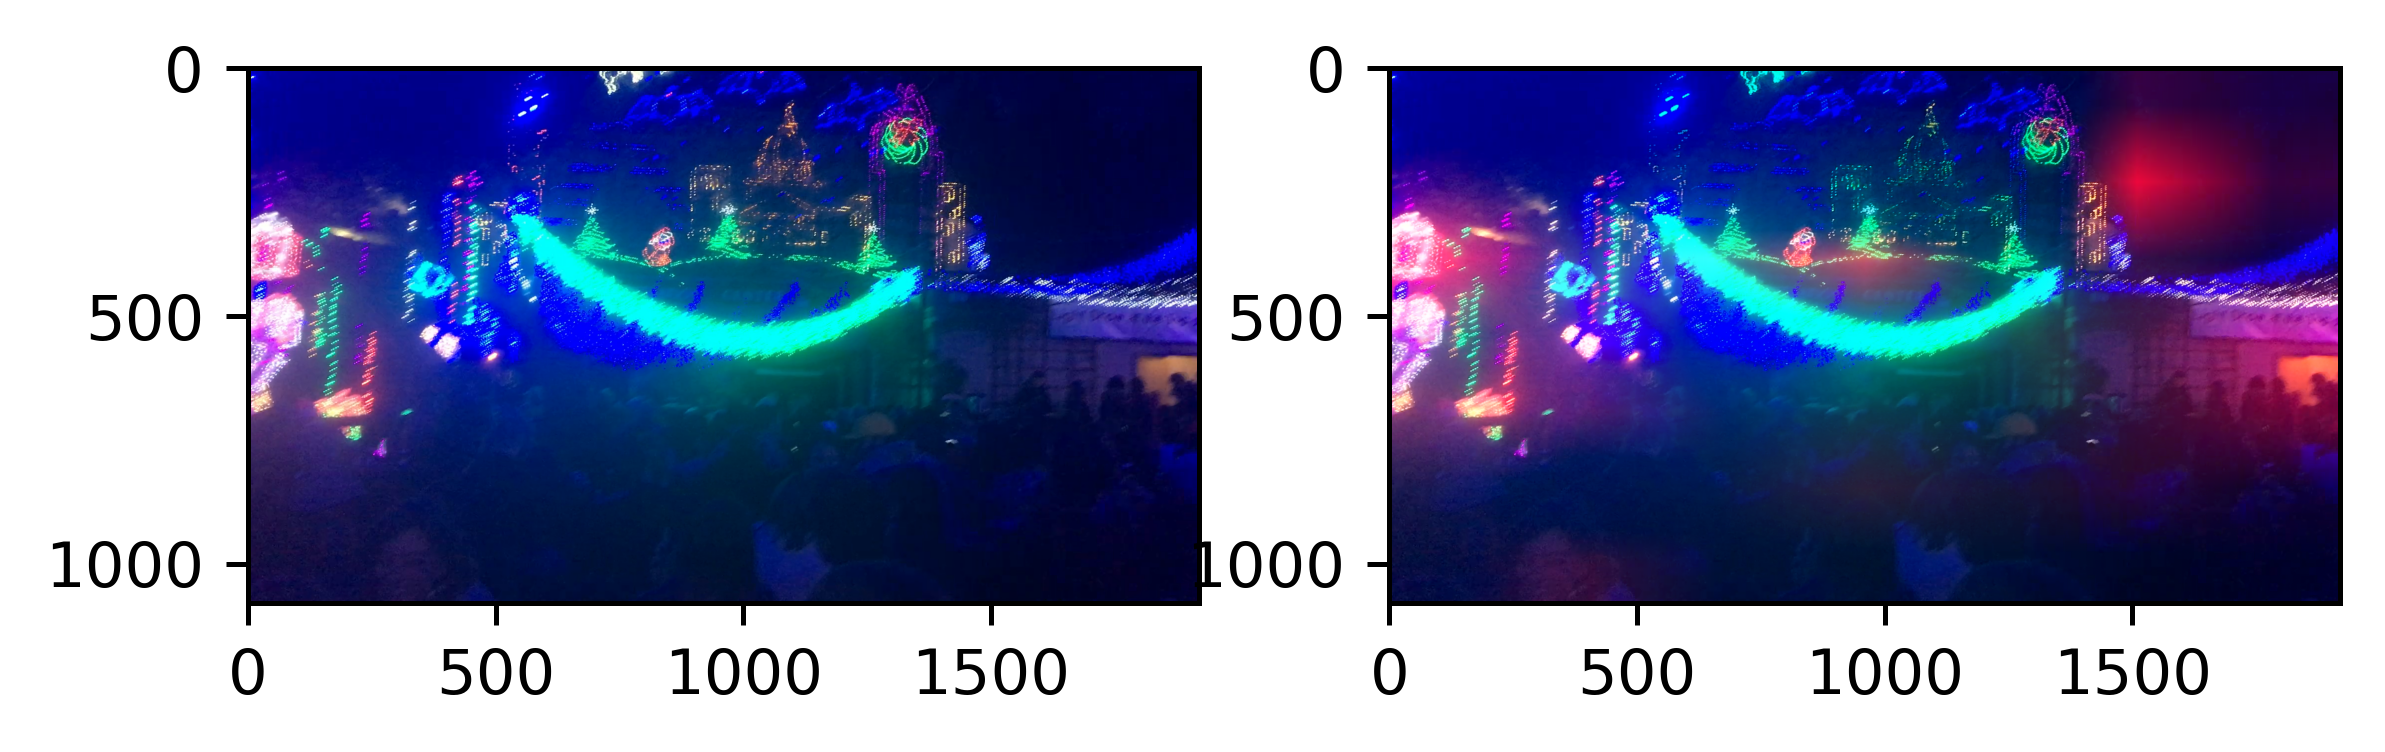

In [37]:
## see the spatial-temporal quality localization for a reference
def init_demo_reader(path, i):
    from decord import VideoReader, cpu
    video_names = [ele.split(',')[0] for ele in open(f'{path}/labels.txt').readlines()]
    frame_reader = VideoReader(f'{path}/{video_names[i]}', ctx=cpu(0))
    return frame_reader

frame_reader = init_demo_reader(dataset_path, q)
video_names = [ele.split(',')[0] for ele in open(f'{dataset_path}/labels.txt').readlines()]


r_index = random.randrange(128) #random.randrange(len(data['frame_inds']))
print(f'Showing the quality map of frame {data["frame_inds"][r_index]}:')
frame_index = data['frame_inds'][r_index]
frame = frame_reader[frame_index]
frame_quality_map = demo_result[r_index // 2]
frame_attention_map_41 = demo_attention_fanet_41[0][r_index // 2] #+ demo_attention_fanet_41[1][r_index // 2]
frame_attention_map_42 = demo_attention_fanet_42[0][r_index // 2] #+ demo_attention_fanet_42[1][r_index // 2]


fragment = (vfrag.permute(0,2,3,4,1).reshape((128,) + vfrag.shape[-2:] + (3,)).cpu() * inference_set.std + inference_set.mean).numpy()[r_index]

frame_quality_map = frame_quality_map.cpu().numpy()
qlt = cv2.resize(rescale(frame_quality_map), (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_LINEAR)
plt.figure(dpi=450)
plt.subplot(221)
plt.imshow(frame)
plt.subplot(222)
plt.imshow((frame / 255. - np.stack((qlt,) + (np.zeros_like(qlt),)*2, -1) / 2.).clip(0,1))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


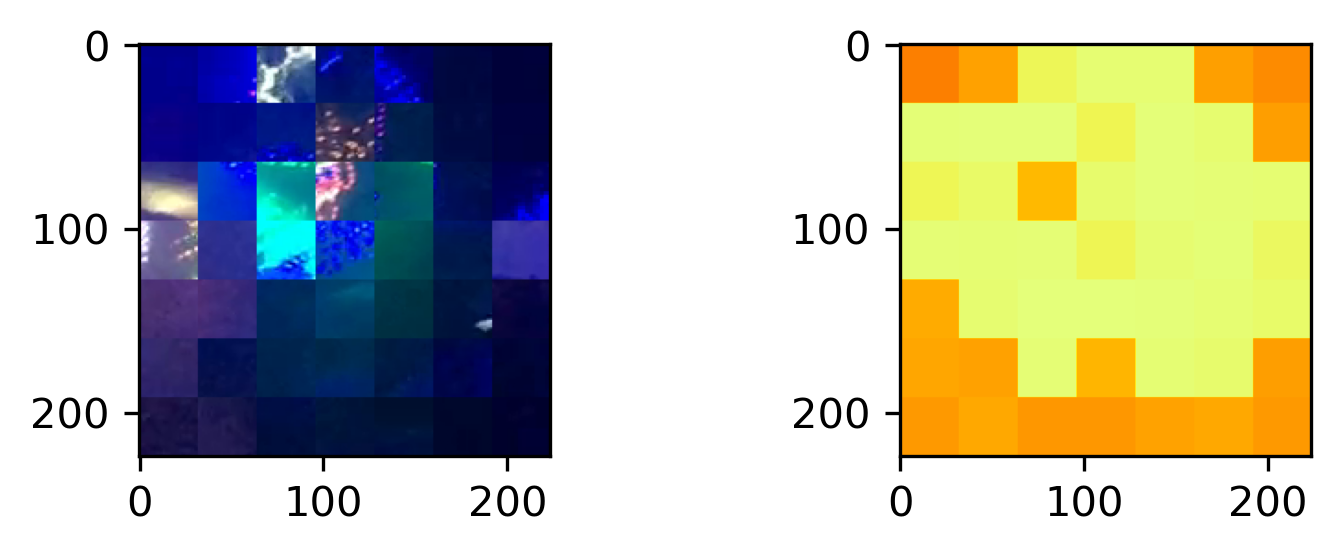

In [80]:
fqlt = cv2.resize(frame_attention_map_41, (fragment.shape[1], fragment.shape[0]), interpolation=cv2.INTER_NEAREST)
plt.figure(dpi=300)
plt.subplot(221)
plt.imshow(fragment / 255.)
plt.subplot(222)
plt.imshow(fqlt, cmap='Wistia') #fragment / 255. - np.stack((fqlt,) + (np.zeros_like(fqlt),)*2, -1) / 2.)
#plt.savefig(f'demos/demo_{video_names[q].split("/")[-1]}.png')
plt.savefig('wistia.png')